In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import xarray as xr 
import pyhomogeneity as hg
import statsmodels.api as sm
import os 

# Function

In [ ]:
# GEV parameter calculation for xarray
def xr_homotest(xarray,dim = 'time', test = 'pettitt'):#,alpha=0.05,sim = 2000):    
    ''' This function homogenity test results for xarray object in one dimension.
    Parameters:
    xarray: Xarray with the variable 
    dim: dimension to apply test function
    test: name of the test (pettitt by default)
    
    Return:
        xarray dataset with all paramters and return value 
        h: boolean for hipotesis test 
        cp: date of change point 
        p: p-value
        U: test parameter
        m1: mean before change point
        m2: mean after change point
    '''
    ds = xr.Dataset()
    if test == 'pettitt':
        f = hg.pettitt_test
    elif test == 'snht_test':
        f = hg.snht_test
    elif test == 'buishand_u_test':
        f = hg.buishand_u_test
    
    def newf(f,x):
        a,b,c,d,g = f(x)#,kwargs = {'alpha': alpha,'sim':sim})
        g1 = g[0]
        g2 = g[1]
        return (a,b,c,d,g1,g2)
    func = lambda x: newf(f,x)
    h, cp, p, U, m1,m2 = xr.apply_ufunc(func,xarray,input_core_dims = [[dim]],
                        output_core_dims = [[] for _ in range(6)],
                        #kwargs={'alpha': alpha,'sim':sim},
                        #kwargs={'f':hg.pettitt_test},
                        # exclude_dims=set(("time",)),                        
                        vectorize = True,
                        )     
    ds['h'] = h
    ds['cp'] = cp
    ds['p'] = p
    ds['U'] = U
    ds['m1'] = m1
    ds['m2'] = m2
    return ds

# Percentage of stations analysis 

In [2]:
ncfiles = [s for s in os.listdir() if '.nc' in s]
ncfiles

['precip_station_1979_2017_South_America_final.nc',
 'tmax_station_1979_2017_South_America_final.nc',
 'tmin_station_1979_2017_South_America_final.nc']

In [100]:
# Time extension for the analysis
# The maximum extension for this files is from 1979 to 2017
start,end = 1981,2005

## Read Datasets

In [101]:
ds_pr = xr.open_dataset(ncfiles[0]).sel(time = slice(str(start),str(end)))
ds_tmax = xr.open_dataset(ncfiles[1]).sel(time = slice(str(start),str(end)))
ds_tmin = xr.open_dataset(ncfiles[2]).sel(time = slice(str(start),str(end)))

<xarray.Dataset>
Dimensions:  (station: 910, time: 9131)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2005-12-31
  * station  (station) object '9_de_Julio' 'Acarau' ... 'Zavalla_Inta' 'Ze_Doca'
    lat      (station) float64 ...
    lon      (station) float64 ...
Data variables:
    pr       (time, station) float64 ...
    alt      (station) float64 ...
    country  (station) object ...

## Precipitation analysis

Check non negative values

In [97]:
ds_pr.pr.where(ds_pr.pr < 0,drop = True)

<xarray.DataArray 'pr' (time: 0, station: 0)>
array([], shape=(0, 0), dtype=float64)
Coordinates:
  * time     (time) datetime64[ns] 
  * station  (station) object 
    lat      (station) float64 
    lon      (station) float64 
Attributes:
    units:    mm/day

## Percentage of records

In [109]:
records_by_year = ds_pr.pr.groupby('time.year').count('time')

In [130]:
# fraction of total registers by station
p = ds_pr.pr.count('time')/len(ds_pr.time)

Text(0.5, 1.0, 'SAM stations 1981 - 2005 \n precipitation')

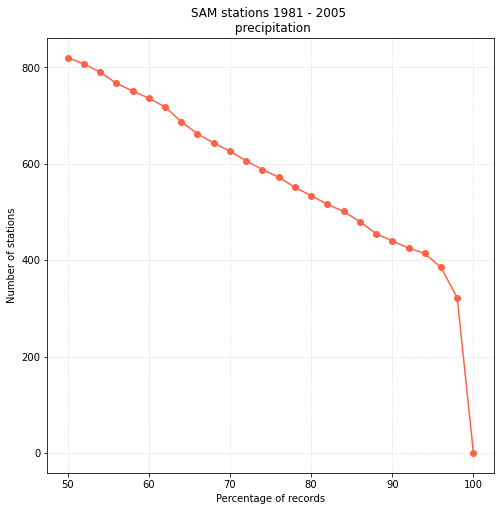

In [134]:
# number of stations vs percent
levels = np.arange(0.5,1.02,0.02)
num_stations = list()
for lev in levels:
    num_stations.append(len(ds_pr.pr.where(p >= lev,drop=True).station))
fig,ax = plt.subplots(figsize = (8,8))
ax.plot(levels*100,num_stations,marker = 'o',color = 'tomato')
ax.grid(ls = '--',color = 'gray',alpha = 0.2)
ax.set_xlabel('Percentage of records')
ax.set_ylabel('Number of stations')
ax.set_title('SAM stations 1981 - 2005 \n precipitation')

In [138]:
# Estaciones con 90% de registros 
pr = ds_pr.where(p >= 0.90,drop = True)
pr

<xarray.Dataset>
Dimensions:  (station: 440, time: 9131)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2005-12-31
  * station  (station) object '9_de_Julio' 'Adolfo_Matthei' ... 'Ze_Doca'
    lat      (station) float64 -35.45 -40.59 -34.57 ... -17.6 -33.03 -3.26
    lon      (station) float64 -60.88 -73.11 -58.42 ... -69.48 -61.47 -45.65
Data variables:
    pr       (time, station) float64 3.0 nan 2.9 0.0 0.0 ... 0.0 0.0 0.0 0.0 3.5
    alt      (station) float64 76.0 55.0 6.0 3.244e+03 ... 4.08e+03 50.0 45.28
    country  (station) object 'Argentina' 'Chile' ... 'Argentina' 'Brazil'

In [5]:
ts = ds_pr.pr.isel(station = 0)
ts

<xarray.DataArray 'pr' (time: 14245)>
array([3.4, 0. , 0. , ..., 0. , 0. , 0. ])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2017-12-31
    station  <U10 '9_de_Julio'
    lat      float64 -35.45
    lon      float64 -60.88
Attributes:
    units:    mm/day

In [6]:
pettitt_res = hg.pettitt_test(ts, alpha=0.05)
pettitt_res

Pettitt_Test(h=False, cp=3935, p=0.39355, U=865855.0, avg=mean(mu1=2.8335451080050826, mu2=2.8982104439663603))

In [14]:
pettitt_res[-1][0]

2.8335451080050826

In [68]:
xx = xr_homotest(ds_pr.pr.isel(station =slice(0,4)))
xx

<xarray.Dataset>
Dimensions:  (station: 4)
Coordinates:
  * station  (station) object '9_de_Julio' 'Acarau' 'Acobamba' 'Adolfo_Matthei'
    lat      (station) float64 -35.45 -2.88 -12.86 -40.59
    lon      (station) float64 -60.88 -40.14 -74.56 -73.11
Data variables:
    h        (station) bool False True True True
    cp       (station) int32 3935 1849 9768 10167
    p        (station) float64 0.4053 0.00035 0.0 0.0002
    U        (station) float64 8.659e+05 1.249e+06 1.766e+06 1.825e+06
    m1       (station) float64 2.834 1.609 1.704 3.6
    m2       (station) float64 2.898 3.467 2.198 3.083

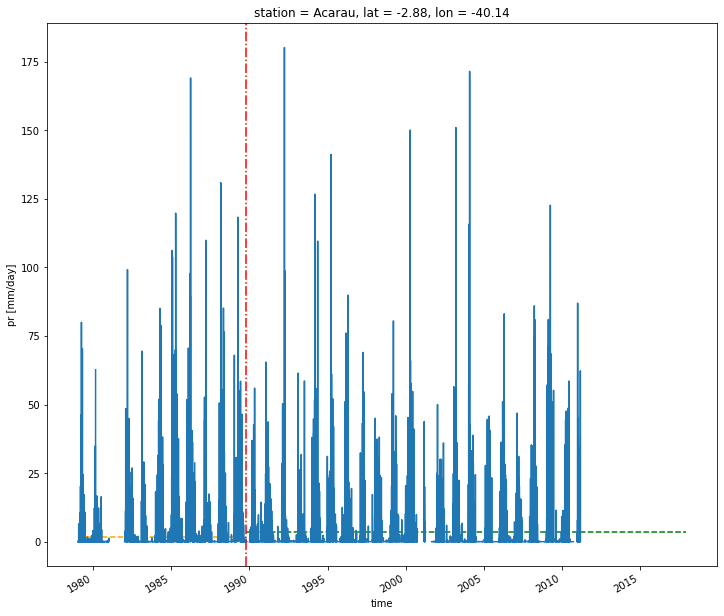

In [81]:
loc = ds_pr.time.isel(time = 3935).values
mn = ds_pr.time.min().values
mx = ds_pr.time.max().values
mu1 = xx.isel(station = 1).m1
mu2 = xx.isel(station = 1).m2
fig,ax = plt.subplots(figsize = (12,10))
ax.hlines(mu1, xmin=mn, xmax=loc, linestyles='--', colors='orange',lw=1.5, label='mu1 : ' + str(np.round(mu1,2)))
ax.hlines(mu2, xmin=loc, xmax=mx, linestyles='--', colors='g', lw=1.5, label='mu2 : ' + str(np.round(mu2,2)))
ds_pr.pr.isel(station = 1).plot(ax = ax)
ax.axvline(x=loc, linestyle='-.' , color='red', lw=1.5, label='Change point')

Temperature Analysis

In [83]:
ds_tmax = xr.open_dataset(ncfiles[1])
ds_tmax

<xarray.Dataset>
Dimensions:  (station: 574, time: 14245)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2017-12-31
  * station  (station) object '9_de_Julio' 'Acarau' ... 'Zavalla_Inta' 'Ze_Doca'
    lat      (station) float64 ...
    lon      (station) float64 ...
Data variables:
    tmax     (time, station) float64 ...
    alt      (station) float64 ...
    country  (station) object ...

In [85]:
yy = xr_homotest(ds_tmax.tmax.isel(station =slice(0,4)))
yy

<xarray.Dataset>
Dimensions:  (station: 4)
Coordinates:
  * station  (station) object '9_de_Julio' 'Acarau' 'Acobamba' 'Adolfo_Matthei'
    lat      (station) float64 -35.45 -2.88 -12.86 -40.59
    lon      (station) float64 -60.88 -40.14 -74.56 -73.11
Data variables:
    h        (station) bool True True True True
    cp       (station) int32 10515 6372 5588 7407
    p        (station) float64 0.0 0.0 0.0 0.0
    U        (station) float64 2.974e+06 9.581e+06 8.452e+06 3.139e+06
    m1       (station) float64 22.49 31.45 18.0 17.27
    m2       (station) float64 23.41 32.4 18.87 16.55

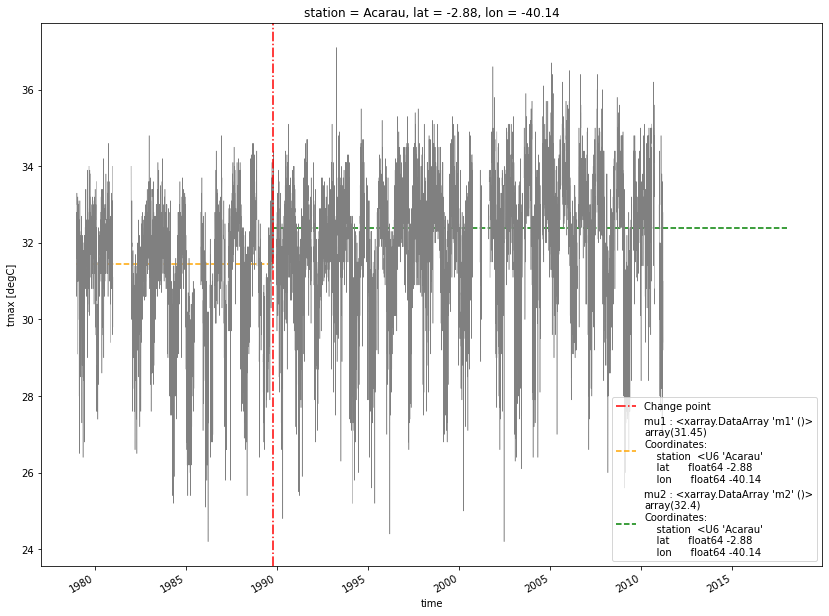

In [93]:
loc = ds_tmax.time.isel(time = 3935).values
mn = ds_tmax.time.min().values
mx = ds_tmax.time.max().values
mu1 = yy.isel(station = 1).m1
mu2 = yy.isel(station = 1).m2
fig,ax = plt.subplots(figsize = (14,10))
ax.hlines(mu1, xmin=mn, xmax=loc, linestyles='--', colors='orange',lw=1.5, label='mu1 : ' + str(np.round(mu1,2)))
ax.hlines(mu2, xmin=loc, xmax=mx, linestyles='--', colors='g', lw=1.5, label='mu2 : ' + str(np.round(mu2,2)))
ds_tmax.tmax.isel(station = 1).plot(ax = ax,lw = 0.5,color = 'gray')
ax.axvline(x=loc, linestyle='-.' , color='red', lw=1.5, label='Change point')
ax.legend()

In [84]:
ds_tmin = xr.open_dataset(ncfiles[2])
ds_tmin

<xarray.Dataset>
Dimensions:  (station: 606, time: 14245)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2017-12-31
  * station  (station) object '9_de_Julio' 'Acarau' ... 'Zavalla_Inta' 'Ze_Doca'
    lat      (station) float64 ...
    lon      (station) float64 ...
Data variables:
    tmin     (time, station) float64 ...
    alt      (station) float64 ...
    country  (station) object ...

In [104]:
xx.to_netcdf('pettit_test_1_borrar.nc')

In [105]:
xy = xr.open_dataset('pettit_test_1_borrar.nc')
xy

<xarray.Dataset>
Dimensions:  (station: 4)
Coordinates:
  * station  (station) object '9_de_Julio' 'Acarau' 'Acobamba' 'Adolfo_Matthei'
    lat      (station) float64 ...
    lon      (station) float64 ...
Data variables:
    h        (station) bool ...
    cp       (station) int32 ...
    p        (station) float64 ...
    U        (station) float64 ...
    m1       (station) float64 ...
    m2       (station) float64 ...

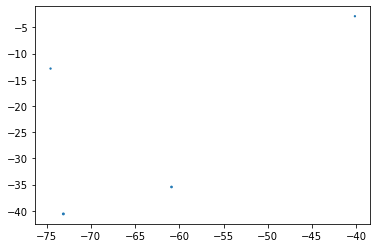

In [106]:
plt.scatter(xy.lon,xy.lat,xy.m1)